In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, cross_validate, KFold

from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from utils import *

In [3]:
%load_ext autoreload
%autoreload 2

### Reading data

In [4]:
path = ''
data = pd.read_excel(path + 'Oncothromb_bbddMarzo2018.xlsx')

In [5]:
data['caseAtVisit'].value_counts()

1.0    47
0.0    32
2.0    13
3.0     4
Name: caseAtVisit, dtype: int64

In [7]:
data['diabetesM'].value_counts()

No    255
-      77
Sí     76
Name: diabetesM, dtype: int64

In [9]:
gen_data, clinical_data, X, y = preprocess_data(data, drop_na=True, summary=True)

Initial shape: (408, 26)
Genetic data shape: (398, 11)
Clinical data shape: (398, 20)
Target shape: (398,)

Number of No-VTE (0) and VTE (1): [320  78]

               Variable  VTE (n)  VTE (%)  No-VTE (n)  No-VTE (%)
0                  sexe       29     37.2         109        34.1
1                edatDx       65   1126.0          64      1040.9
2             diabetesM       14     17.9          61        19.1
3               fumador       22     28.2          68        21.2
4                Family        6      7.7          12         3.8
5                   bmi       40     51.3         145        45.3
6                dislip       32     41.0         107        33.4
7              hta_desc       36     46.2         146        45.6
8               khorana       18     23.1          57        17.8
9           hemoglobina        6      7.7          17         5.3
10            plaquetes       16     20.5          72        22.5
11            leucocits       16     20.5          58  

### Target variable

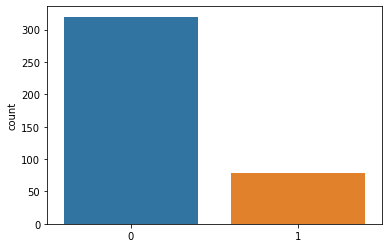

In [27]:
sns.countplot(y)
plt.show()

In [28]:
sum(elem==0 for elem in y), sum(elem==1 for elem in y)
# IT SHOULD BE (320, 71) !!!

(320, 78)

### 1) Genetic variables
Here I consider the genetic variables indicated in the paper (1. Development of a genetic risk score)

In [29]:
gen_data.tail()

,rs6025,rs4524,rs1799963,rs1801020,rs5985,rs121909548,rs2232698,rs8176719,rs7853989,rs8176749,rs8176750
393,0,1,1,0,0,0,1,2,0,0,1
394,0,1,0,0,0,0,0,1,0,0,1
395,0,1,0,0,0,0,0,2,1,1,0
396,0,2,0,0,2,0,0,1,0,0,0
397,0,2,0,1,1,0,0,0,0,0,0


In [30]:
# we can compare the number of patients in each group to see that it coincides with the results in Table 1
print(len(gen_data[gen_data['rs6025']==1])) # 9
print(len(gen_data[gen_data['rs5985']==2])) # 22

9
22


In [32]:
# fitting a logistic model
gen_model = sm.Logit(y, sm.add_constant(gen_data)).fit(maxiter=100, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.482022
         Iterations: 95
         Function evaluations: 97
         Gradient evaluations: 97


In [33]:
gen_model.summary() # P>|z| differ from the paper results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  398
Model:                          Logit   Df Residuals:                      386
Method:                           MLE   Df Model:                           11
Date:                Tue, 11 May 2021   Pseudo R-squ.:                 0.02578
Time:                        15:29:42   Log-Likelihood:                -191.84
converged:                       True   LL-Null:                       -196.92
Covariance Type:            nonrobust   LLR p-value:                    0.5166
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.1476      0.452     -4.747      0.000      -3.034      -1.261
rs6025          0.6977      0.728      0.958      0.338      -0.729       2.125
rs4524          0.4087      0.236      1.735      0.083      -0.053       0.870
rs1799963      -0.4106      0.759     -0.541      0.588      -1.898       1.077
rs1801020      -0.0867      0.236     -0.367      0.714      -0.550       0.377
rs5985          0.2063      0.210      0.981      0.327      -0.206       0.619
rs121909548    -8.0447    105.778     -0.076      0.939    -215.366     199.276
rs2232698       1.4237      0.705      2.019      0.044       0.041       2.806
rs8176719       0.0524      0.211      0.248      0.804      -0.361       0.466
rs7853989      -0.6419      1.092     -0.588      0.557      -2.783       1.499
rs8176749       0.3511      1.151      0.305      0.760      -1.905       2.607
rs8176750      -0.1231      0.414     -0.297      0.766      -0.935       0.689
===============================================================================
"""

**Computing p-values using permutation test**

In [39]:
lr = LogisticRegression(penalty='none')
gen_pvalues = perm_test(gen_data, y, lr)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [40]:
# close to the previous ones
gen_pvalues 

[0.482, 0.052, 0.552, 0.72, 0.314, 0.86, 0.19, 0.818, 0.512, 0.74, 0.76]

In [41]:
gen_model.pvalues

const          0.000002
rs6025         0.337972
rs4524         0.082800
rs1799963      0.588432
rs1801020      0.713697
rs5985         0.326839
rs121909548    0.939377
rs2232698      0.043517
rs8176719      0.803904
rs7853989      0.556729
rs8176749      0.760302
rs8176750      0.766459
dtype: float64

In [42]:
# def permutation_test(X, y, model, n=100):
  
#   lr.fit(X, y)
#   ppred = lr.predict(X)
#   acc = sum(ppred == y) / len(y)

#   pX = X.copy()

#   p_values = []
#   for col in X.columns:
    
#     p_acc = []
#     for i in range(n):
#       pX[col] = np.random.permutation(X[col].values)
#       lr.fit(pX,y)
#       ppred = lr.predict(pX)
#       p_acc.append(sum(ppred == y) / len(y))

#     p_value = len(np.where(p_acc >= acc)[0]) / n
#     p_values.append(p_value)

#   return p_values

### 2) Clinical variables
Now I select the clinical variables considered in the paper (2. Selection of clinical variables)

In [43]:
clinical_data.tail()

,sexe,edatDx,diabetesM,fumador,Family,bmi,dislip,hta_desc,khorana,hemoglobina,plaquetes,leucocits,tipusTumor_colon,tipusTumor_pancreas,tipusTumor_pulmon,tipusTumor_esofago,tipusTumor_estomago,estadiGrup_I_II,estadiGrup_III,estadiGrup_IV
393,0,67,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
394,0,60,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1
395,0,81,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1
396,0,73,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0
397,0,57,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1


In [44]:
clinical_data.shape

(398, 20)

In [45]:
# we can compare the number of patients in each group to see that it coincides with the results in Table 1
len(clinical_data[clinical_data['sexe']==1]) # 135

138

In [46]:
sum(y[[clinical_data[clinical_data['sexe']==1].index]]) # should be 27

<ipython-input-46-8e40363ebf78>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sum(y[[clinical_data[clinical_data['sexe']==1].index]]) # should be 27


29

In [55]:
# fit the model with maximum likelihood function
clinical_model = sm.Logit(y, sm.add_constant(clinical_data)).fit(maxiter=100, method='newton')

Optimization terminated successfully.
         Current function value: 0.434416
         Iterations 7


In [56]:
clinical_model.summary()

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  398
Model:                          Logit   Df Residuals:                      379
Method:                           MLE   Df Model:                           18
Date:                Tue, 11 May 2021   Pseudo R-squ.:                  0.1220
Time:                        15:38:53   Log-Likelihood:                -172.90
converged:                       True   LL-Null:                       -196.92
Covariance Type:            nonrobust   LLR p-value:                 0.0001481
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9035        nan        nan        nan         nan         nan
sexe                    0.0086      0.299      0.029      0.977      -0.578       0.595
edatDx                  0.0107      0.014      0.753      0.451      -0.017       0.038
diabetesM              -0.4694      0.388     -1.209      0.227      -1.230       0.292
fumador                 0.2912      0.338      0.860      0.390      -0.372       0.955
Family                  0.8024      0.585      1.371      0.170      -0.345       1.950
bmi                     0.5859      0.297      1.974      0.048       0.004       1.168
dislip                  0.3384      0.304      1.114      0.265      -0.257       0.934
hta_desc               -0.2105      0.300     -0.701      0.483      -0.799       0.378
khorana                 0.0299      0.547      0.055      0.956      -1.042       1.102
hemoglobina             1.0077      0.561      1.795      0.073      -0.093       2.108
plaquetes              -0.1161      0.408     -0.284      0.776      -0.916       0.684
leucocits              -0.1446      0.435     -0.333      0.739      -0.997       0.707
tipusTumor_colon       -0.6377   1.15e+07  -5.53e-08      1.000   -2.26e+07    2.26e+07
tipusTumor_pancreas     0.7683   1.15e+07   6.66e-08      1.000   -2.26e+07    2.26e+07
tipusTumor_pulmon      -0.7748   1.15e+07  -6.72e-08      1.000   -2.26e+07    2.26e+07
tipusTumor_esofago     -0.5444   1.15e+07  -4.72e-08      1.000   -2.26e+07    2.26e+07
tipusTumor_estomago    -0.7149   1.15e+07   -6.2e-08      1.000   -2.26e+07    2.26e+07
estadiGrup_I_II        -1.5895        nan        nan        nan         nan         nan
estadiGrup_III         -0.5077        nan        nan        nan         nan         nan
estadiGrup_IV           0.1936        nan        nan        nan         nan         nan
=======================================================================================
"""

In [57]:
clinical_pvalues = perm_test(clinical_data, y, lr)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [58]:
clinical_pvalues 

[0.998,
 0.45,
 0.202,
 0.374,
 0.206,
 0.03,
 0.226,
 0.538,
 0.948,
 0.13,
 0.776,
 0.752,
 0.062,
 0.036,
 0.052,
 0.39,
 0.084,
 0.0,
 0.244,
 0.696]

In [59]:
clinical_model.pvalues

const                       NaN
sexe                   0.977151
edatDx                 0.451487
diabetesM              0.226773
fumador                0.389539
Family                 0.170490
bmi                    0.048393
dislip                 0.265161
hta_desc               0.483021
khorana                0.956405
hemoglobina            0.072662
plaquetes              0.776136
leucocits              0.739442
tipusTumor_colon       1.000000
tipusTumor_pancreas    1.000000
tipusTumor_pulmon      1.000000
tipusTumor_esofago     1.000000
tipusTumor_estomago    1.000000
estadiGrup_I_II             NaN
estadiGrup_III              NaN
estadiGrup_IV               NaN
dtype: float64

### 3) Genetical and clinical markers included in the TiC-Onco risk score model
Here I use the variables selected in steps 1 and 2 of the paper (see table 3)

In [69]:
X.head()

,rs2232698,rs6025,rs5985,rs4524,bmi,Family,primary_tumour_site,tumour_stage
0,0,0,0,2,0,0,2,1
1,0,0,1,1,1,0,0,1
2,0,0,0,1,0,0,2,0
3,0,0,0,2,0,0,1,1
4,0,0,0,2,0,0,0,1


In [70]:
X.shape

(398, 8)

### Evaluating TiC-Onco risk score

In [82]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2001)

In [72]:
model = sm.Logit(endog=y_train, exog=X_train).fit(maxiter=100, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.545947
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49


In [73]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                            7
Date:                Tue, 11 May 2021   Pseudo R-squ.:                -0.04949
Time:                        15:49:26   Log-Likelihood:                -162.69
converged:                       True   LL-Null:                       -155.02
Covariance Type:            nonrobust   LLR p-value:                     1.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
rs2232698               0.9623      0.852      1.130      0.258      -0.707       2.632
rs6025                  0.2827      0.890      0.318      0.751      -1.461       2.027
rs5985                 -0.1336      0.229     -0.583      0.560      -0.583       0.316
rs4524                 -0.7462      0.148     -5.035      0.000      -1.037      -0.456
bmi                    -0.3874      0.259     -1.495      0.135      -0.895       0.120
Family                  0.3336      0.645      0.518      0.605      -0.930       1.597
primary_tumour_site     0.0395      0.150      0.264      0.792      -0.254       0.333
tumour_stage            0.4488      0.271      1.656      0.098      -0.082       0.980
=======================================================================================
"""

In [74]:
perm_test(X, y, lr)

[0.148, 0.636, 0.49, 0.034, 0.072, 0.18, 0.018, 0.0]

In [75]:
# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [76]:
def evaluate_model(y_train, y_hat_train, y_test, y_hat_test):
  
  # compute roc curve
  fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
  fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_test)
  roc_auc = auc(fpr, tpr)
  roc_auc2 = auc(fpr2, tpr2)
  print("AUC score (train):", round(roc_auc,4))
  print("AUC score (test):", round(roc_auc2,4))

  plt.title('Receiver Operating Characteristic (test)')
  plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  # thresholds (specificity ~ 80%, as indicated in the paper)
  idx = np.argmin(abs((1-fpr) - 0.8))
  idx2 = np.argmin(abs((1-fpr2) - 0.8))
  threshold = thresholds[idx] 
  threshold2 = thresholds2[idx2]

  # high risk: TiC-Onco risk >= threshold
  y_hat_train = y_pred_train >= threshold  
  y_hat_test = y_pred_test >= threshold2 
  acc = sum(y_hat_train == y_train) / len(y_train)
  acc2 = sum(y_hat_test == y_test) / len(y_test)
  print("\nAccuracy in train set (%):", round(acc*100, 2))
  print("Accuracy in test set (%):", round(acc2*100, 2))

  # confusion matrix 
  for subset, y, y_hat in zip(['Train set','Test set'], [y_train,y_test], [y_hat_train,y_hat_test]):
    print("\n=====" + subset + "=====")
    tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
    print(confusion_matrix(y, y_hat))
    print()

    sensivity = tp / (tp+fn)
    specificity = tn / (fp+tn)
    PPV = tp / (tp+fp)
    NPV = tn / (fn+tn)

    print("Sensivity (%):", round(sensivity*100,2))
    print("Specificity (%):", round(specificity,4)*100)
    print("Precision (%):", round(PPV,4)*100)
    print("NPV (%):", round(NPV,4)*100)

AUC score (train): 0.5292
AUC score (test): 0.539


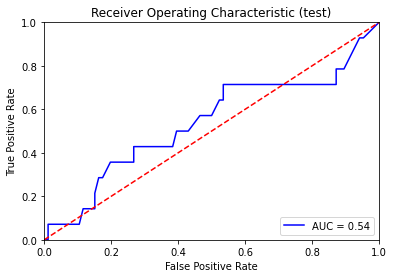


Accuracy in train set (%): 66.11
Accuracy in test set (%): 74.0

=====Train set=====
[[186  48]
 [ 53  11]]

Sensivity (%): 17.19
Specificity (%): 79.49000000000001
Precision (%): 18.64
NPV (%): 77.82

=====Test set=====
[[69 17]
 [ 9  5]]

Sensivity (%): 35.71
Specificity (%): 80.23
Precision (%): 22.73
NPV (%): 88.46000000000001


In [77]:
evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

### Evaluating Khorana score

In [80]:
# High risk: Khorana >= 3
pred_khorana = [1 if score>=3 else 0 for score in data['khorana']]
len(pred_khorana)

408

In [79]:
acc_khorana = sum(pred_khorana == y) / len(y)
print("Accuracy (%):", round(acc_khorana*100, 2))

<ipython-input-79-ddc1e6bd0fae>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  acc_khorana = sum(pred_khorana == y) / len(y)


TypeError: 'bool' object is not iterable

In [ ]:
tn, fp, fn, tp = confusion_matrix(y, pred_khorana).ravel()
confusion_matrix(y, pred_khorana)

array([[259,  53],
       [ 61,  18]])

In [ ]:
sensivity_khorana = tp / (tp+fn)
specificity_khorana = tn / (fp+tn)
PPV_khorana = tp / (tp+fp)
NPV_khorana = tn / (fn+tn) 

In [ ]:
print("Sensivity (%):", round(sensivity_khorana*100,2))
print("Specificity (%):", round(specificity_khorana,4)*100)
print("PPV (%):", round(PPV_khorana,4)*100)
print("NPV (%):", round(NPV_khorana,4)*100)

Sensivity (%): 22.78
Specificity (%): 83.00999999999999
PPV (%): 25.35
NPV (%): 80.94


## Testing some scikit-learn models

Here I fit some models using all the features considered in steps I and II.

Code adapted from https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

In [ ]:
X_all = pd.concat((gen_data, clinical_data), axis=1)
print(X_all.shape)
X_all.head()

(391, 31)


,rs6025,rs4524,rs1799963,rs1801020,rs5985,rs121909548,rs2232698,rs8176719,rs7853989,rs8176749,rs8176750,sexe,edatDx,diabetesM,fumador,Family,bmi,dislip,hta_desc,khorana,hemoglobina,plaquetes,leucocits,tipusTumor_colon,tipusTumor_pancreas,tipusTumor_pulmon,tipusTumor_esofago,tipusTumor_estomago,estadiGrup_I_II,estadiGrup_III,estadiGrup_IV
0,0,2,0,1,0,0,0,0,0,0,0,0,78,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
1,0,1,0,0,1,0,0,2,0,0,0,0,50,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,1,0,1,0,0,0,0,0,0,0,0,71,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
3,0,2,0,1,0,0,0,1,0,0,0,0,68,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1
4,0,2,0,0,0,0,0,1,0,0,1,0,71,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_all_scaled = scaler.fit_transform(X_all)

In [ ]:
# train/test split
# X_train, X_val, y_train, y_val = train_test_split(X_all, y, test_size=0.25, random_state=2037)
# X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=2037)
# print(X_train.shape, X_val.shape, X_test.shape)

In [ ]:
def run_exps(models, X_train, y_train):
    dfs = []
    results = []
    names = []
    scoring = ['roc_auc', 'precision', 'recall', 'balanced_accuracy']
    target_names = ['noVTE', 'VTE']
    
    for name, model in models:
        kfold = KFold(n_splits=5, shuffle=True, random_state=2037)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=False)
        # clf = model.fit(X_train, y_train)
        # y_pred = clf.predict(X_test)
        # print(name)
        # print(classification_report(y_test, y_pred, target_names=target_names))
    
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

    final = pd.concat(dfs, ignore_index=True)
    return final

In [ ]:
SEED = 1135
class_weight = {1:20}

models = [
          ('LR', LogisticRegression(solver='liblinear', max_iter=300, random_state=SEED, class_weight=class_weight)), 
          ('RF', RandomForestClassifier(n_estimators=80, random_state=SEED, class_weight=class_weight)),
          ('KNN', KNeighborsClassifier(n_neighbors=5)),
          ('SVM', SVC(random_state=SEED, class_weight=class_weight)), 
          ('LGB', LGBMClassifier(class_weight=class_weight, random_state=SEED)),
          ('XGB', XGBClassifier(random_state=SEED, class_weight=class_weight))
        ]

final = run_exps(models, X_all_scaled, y)

In [ ]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=50, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df, id_vars=['model'], var_name='metrics', value_name='values')

time_metrics = ['fit_time','score_time']

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

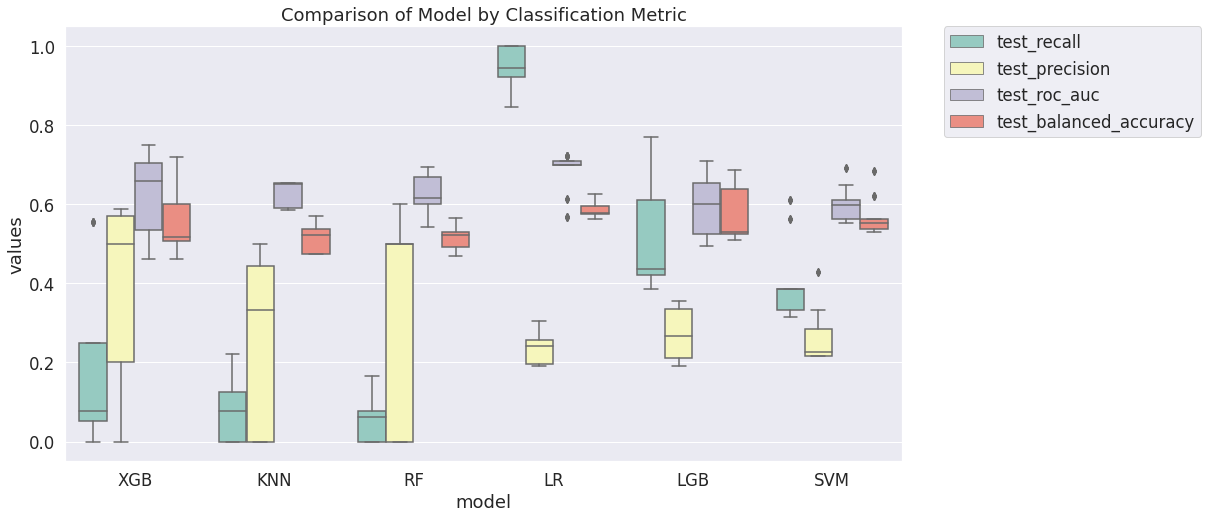

In [ ]:
# plot performance metrics from the 5-fold cross validation
plt.figure(figsize=(15, 8))
sns.set(font_scale=1.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
# plt.savefig('./benchmark_models_performance.png',dpi=300)
plt.show()

In [ ]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.mean, np.std])

test_recall           test_precision           test_roc_auc            \
             mean       std           mean       std         mean       std   
model                                                                         
KNN      0.076538  0.081832       0.244667  0.215353     0.629581  0.028852   
LGB      0.532786  0.138930       0.273246  0.056679     0.603606  0.074756   
LR       0.947072  0.048476       0.234125  0.034225     0.684559  0.051695   
RF       0.061122  0.053695       0.354000  0.247609     0.627207  0.049425   
SVM      0.408131  0.097761       0.268532  0.062308     0.603130  0.040009   
XGB      0.205484  0.198525       0.413647  0.218363     0.633263  0.108565   

      test_balanced_accuracy            
                        mean       std  
model                                   
KNN                 0.513990  0.036819  
LGB                 0.581041  0.071769  
LR                  0.584104  0.018023  
RF                  0.517773  0.029789  
SVM                 0.569019  0.043550  
XGB                 0.571767  0.088114

Select better model (using validation results):

In [ ]:
clf = models[5][1]
clf.fit(X_train, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', class_weight={1: 20},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1135,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

AUC score (train): 0.6154
AUC score (test): 0.5069


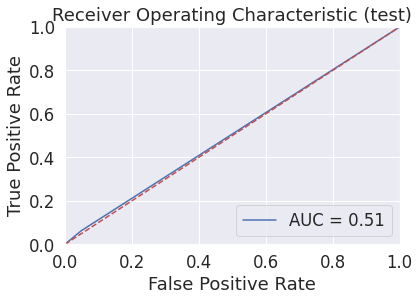


Accuracy in train set (%): 81.23
Accuracy in test set (%): 80.61

=====Train set=====
[[221   9]
 [ 46  17]]

Sensivity (%): 26.98
Specificity (%): 96.09
Precision (%): 65.38000000000001
NPV (%): 82.77

=====Test set=====
[[78  4]
 [15  1]]

Sensivity (%): 6.25
Specificity (%): 95.12
Precision (%): 20.0
NPV (%): 83.87


In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)